In [1]:
import spike.spike_analysis.spike_collection as sc
import spike.spike_analysis.spike_recording as sr
import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.normalization as norm
import spike.spike_analysis.single_cell as single_cell
import spike.spike_analysis.spike_collection as collection
import spike.spike_analysis.zscoring as zscoring
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import behavior.boris_extraction as boris
import matplotlib.pyplot as plt
import pickle
import re

## Formatting for Pandas

In [2]:
pd.set_option('display.max_colwidth', 0)  # 0 means unlimited in newer pandas versions

# Show all rows
pd.set_option("display.max_rows", None)

# Show all columns
pd.set_option("display.max_columns", None)

# Don’t truncate column contents
pd.set_option("display.max_colwidth", None)

# Expand the display to the full width of the screen
pd.set_option("display.width", 0)


In [3]:
spike_collection_json_path = r'C:\Users\thoma\Code\ResearchCode\diff_fam_social_memory_ephys\spike_collection.json\spike_collection.json'

## Reloading Main 2 Packages

In [4]:
import importlib
importlib.reload(sc)
importlib.reload(zscoring)

<module 'spike.spike_analysis.zscoring' from 'c:\\Users\\thoma\\Code\\ResearchCode\\diff_fam_social_memory_ephys\\spike\\spike_analysis\\zscoring.py'>

### Loading in SpikeCollection Object with Recordings and their corresponding event dicts

In [5]:
sp = sc.SpikeCollection.load_collection(spike_collection_json_path)

In [6]:
rec_events = sp.recordings[0].event_dict

# get unique event names from rec_events dictionary
event_names = list(rec_events.keys())
print("Unique event names:", event_names)

Unique event names: ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win']


#### Unique event names: ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win']


In [7]:
# printing unique recording names
recording_names = [rec.name for rec in sp.recordings]
print("Unique recording names:", recording_names)

Unique recording names: ['20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec', '20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged.rec', '20230612_112630_standard_comp_to_training_D1_subj_1-1_t1b3L_box2_merged.rec', '20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec', '20230613_105657_standard_comp_to_training_D2_subj_1-1_t1b2L_box1_merged.rec', '20230613_105657_standard_comp_to_training_D2_subj_1-4_t4b3L_box2_merged.rec', '20230614_114041_standard_comp_to_training_D3_subj_1-1_t1b3L_box1_merged.rec', '20230614_114041_standard_comp_to_training_D3_subj_1-2_t2b2L_box2_merged.rec', '20230616_111904_standard_comp_to_training_D4_subj_1-2_t2b2L_box2_merged.rec', '20230616_111904_standard_comp_to_training_D4_subj_1-4_t4b3L_box1_merged.rec', '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec', '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec', '20230618_100636_standard_c

### Verifying it's in timestamps not ms

In [8]:
# Pick any one recording and unit
recording = sp.recordings[0]  # or choose a specific one
unit_id = list(recording.unit_timestamps.keys())[0]  # get the first available good unit

# Extract the raw spike timestamps
raw_spikes = recording.unit_timestamps[unit_id]

# Show the first few spikes
print(f"Raw spike timestamps for unit {unit_id}:")
print(raw_spikes[:10])

# Convert to milliseconds
converted_spikes_ms = raw_spikes * (1000 / recording.sampling_rate)
print("\nConverted to milliseconds:")
print(converted_spikes_ms[:10])

# Also print min/max to check range
print(f"\nMin raw spike: {raw_spikes.min()} | Max raw spike: {raw_spikes.max()}")
print(f"Min spike time in ms: {converted_spikes_ms.min():.2f} ms | Max: {converted_spikes_ms.max():.2f} ms")


Raw spike timestamps for unit 104:
[276153 503505 649539 686660 752824 757488 768359 782699 783787 820039]

Converted to milliseconds:
[13807.65 25175.25 32476.95 34333.   37641.2  37874.4  38417.95 39134.95
 39189.35 41001.95]

Min raw spike: 276153 | Max raw spike: 68111594
Min spike time in ms: 13807.65 ms | Max: 3405579.70 ms


### Z-Score for an event using baselines of all events in a recording

### Using a significance cutoff score for a 99% 2-tailed confidence interval to determine if the neuron increased firing rate
### Using a significance cutoff score for a 95% 2-tailed confidence interval to determine if the neuron decreased firing rate
These values were suggested to Nancy by Fabricio Do Monte
Found in tylers z_score_compness notebook

In [ ]:
import numpy as np
import pandas as pd

def run_zscore_global_baseline(recording, event_name, pre_window=10, SD=1.65, verbose=False):
    """
    Z-score event firing rates using a *pooled* baseline (all event types) per unit.
    This function calculates the z-score of firing rates for a specific event type
    based on a global baseline computed from all event types in the recording.
    Parameters:
    - recording: SpikeRecording object containing spike data and events.
    - event_name: Name of the event type to analyze.
    - pre_window: Duration in seconds before the event to use for baseline calculation.
    - SD: Number of standard deviations to use for significance thresholding.
    - verbose: If True, prints additional information during processing.
    Returns:
    - A pandas DataFrame containing the z-scores and significance of firing rates for each unit
    for the specified event type.
    """
    # Step 1: Pool all baseline windows across all events for each unit
    global_baseline_counts = {}
    units = getattr(recording, "good_units", None) # get good units if available
    if units is None: # if not, use labels_dict
        units = [unit_id for unit_id, label in recording.labels_dict.items() if label == "good"]

        if verbose:
            print("Using labels_dict to determine good units.")
            print(f"Good units found: {units}\n\nFrom labels_dict: {recording.labels_dict}\n\n")

    # Initialize global baseline list per unit
    for unit_id in units:
        global_baseline_counts[unit_id] = []
    if verbose:
        print(f"Gloabal baseline counts initialized for units: {global_baseline_counts}\n")    

    # Loop through all event types and pool all baselines
    # creates a list of baseline counts for each unit
    for ev_type, event_windows in recording.event_dict.items():
        for unit_id in units:
            spikes = recording.unit_timestamps[unit_id] # number of spikes for this unit
            spikes_ms = spikes * (1000 / recording.sampling_rate) # convert to milliseconds since event_windows are in ms

            for window in event_windows:
                start_event = window[0]
                start_baseline = start_event - int(pre_window * 1000)
                if verbose:
                    print(f"For window {window}, start_event: {start_event}, start_baseline: {start_baseline}, pre_window: {pre_window}")

                end_baseline = start_event
                baseline_count = np.sum((spikes_ms >= start_baseline) & (spikes_ms < end_baseline))
                global_baseline_counts[unit_id].append(baseline_count) # list of counts for this unit appended to global_baseline_counts

                if verbose:
                    print(f"Unit {unit_id}, Event {ev_type}, Baseline count: {baseline_count} in {global_baseline_counts}\n")

    # Step 2: Compute global baseline mean and SD per unit using numpy
    baseline_mean = {u: np.mean(c) for u, c in global_baseline_counts.items()}
    baseline_sd = {u: np.std(c) for u, c in global_baseline_counts.items()}

    # Step 3: For the target event, calculate z-scores
    event_windows = recording.event_dict[event_name]
    event_firing = {}
    rows = []
    for unit_id in units:
        spikes = recording.unit_timestamps[unit_id]
        spikes_ms = spikes * (1000 / recording.sampling_rate)
        event_counts = []
        for window in event_windows:
            start_event = window[0]
            end_event = window[1]
            event_count = np.sum((spikes_ms >= start_event) & (spikes_ms < end_event)) # count spikes in the event window using masking
            event_counts.append(event_count)

        # getting all the important values for z-score calculation per unit
        ev_mean = np.mean(event_counts)
        b_mean = baseline_mean[unit_id]
        b_sd = baseline_sd[unit_id]

        # Calculate z-score
        zscore = np.nan if b_sd == 0 else (ev_mean - b_mean) / b_sd 


        # significance determination based on SD threshold given
        sig = "not sig"
        if not np.isnan(zscore):
            if zscore > SD:
                sig = "increase"
            elif zscore < -SD:
                sig = "decrease"

        rows.append({
            "Recording": recording.name,
            "Event name": event_name,
            "Unit number": unit_id,
            "Global Pre-event M": b_mean,
            "Global Pre-event SD": b_sd,
            "Event M": ev_mean,
            "Event Z-Score": zscore,
            "sig": sig
        })

    df = pd.DataFrame(rows)
    '''
    # Apply significance threshold using np.select
    conditions = [
        (df['Event Z-Score'] > 2.58),
        (df['Event Z-Score'] < -1.96)
    ]
    values = ['increase', 'decrease']
    df['sig'] = np.select(conditions, values, default='not sig')
    '''

    return df


In [39]:
rec = sp.recordings[0]
event_name = "alone_rewarded"  # or any event you know exists

df = zscoring.run_zscore_global_baseline(rec, event_name, pre_window=10, SD=1.65)
df.head(20)

,Recording,Event name,Unit number,Global Pre-event M,Global Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,104,0.939130,1.459821,0.75,-0.129557,not sig
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,11,3.191304,4.476306,2.70,-0.109757,not sig
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,122,1.434783,3.471325,1.85,0.119614,not sig
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,125,10.554348,8.245900,6.90,-0.443171,not sig
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,126,43.439130,33.150621,32.15,-0.340541,not sig
5,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,130,0.686957,0.926567,1.05,0.391816,not sig
6,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,143,10.991304,12.726894,9.70,-0.101463,not sig
7,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,147,0.371739,1.175319,0.60,0.194212,not sig
8,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,158,3.400000,4.478062,5.70,0.513615,not sig
9,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,189,19.228261,9.698614,18.15,-0.111177,not sig


#### 21

In [40]:
df['sig'].value_counts()

sig
not sig     21
increase     1
Name: count, dtype: int64

## Creating Dataframe with Each Event

## Adding Putative Types

## Pkl Dataframe

### Alone Rewarded df

In [41]:
# for every rec in sp.recordings, if event_name in rec.event_dict, run the z-score analysis
all_dfs = []
for rec in sp.recordings:
    if event_name in rec.event_dict:
        df = zscoring.run_zscore_global_baseline(rec, event_name, pre_window=10, SD=1.65)
        all_dfs.append(df)
# Combine all dataframes into one
alone_rewarded_df = pd.concat(all_dfs, ignore_index=True)

print(f"\nTotal number of rows in combined DataFrame: {len(alone_rewarded_df)}")

c:\Users\thoma\miniconda3\envs\ephys_env\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\thoma\miniconda3\envs\ephys_env\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Total number of rows in combined DataFrame: 649


In [42]:
# for every rec in sp.recordings, for every event_name Unique event names: ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win']
all_dfs = []
for rec in sp.recordings:
    for event_name in rec.event_dict.keys():
        df = zscoring.run_zscore_global_baseline(rec, event_name, pre_window=10, SD=1.65)
        all_dfs.append(df)
# Combine all dataframes into one
combined_df = pd.concat(all_dfs, ignore_index=True)
print(f"\nTotal number of rows in combined DataFrame: {len(combined_df)}")


Total number of rows in combined DataFrame: 9517


In [43]:
combined_df.tail(30)

,Recording,Event name,Unit number,Global Pre-event M,Global Pre-event SD,Event M,Event Z-Score,sig
9487,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,overall_pretone,25,0.481818,0.881443,1.500000,1.155130,not sig
9488,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,overall_pretone,27,292.836364,50.268647,314.000000,0.421011,not sig
9489,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,overall_pretone,4,19.381818,22.679980,20.500000,0.049303,not sig
9490,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,overall_pretone,42,345.936364,62.157027,292.500000,-0.859699,not sig
9491,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,overall_pretone,43,2.500000,1.688194,1.500000,-0.592349,not sig
9492,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,overall_pretone,47,3.309091,2.126651,5.000000,0.795104,not sig
9493,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,overall_pretone,49,68.827273,16.788448,81.500000,0.754848,not sig
9494,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,overall_pretone,53,4.809091,8.456837,1.000000,-0.450416,not sig
9495,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,overall_pretone,54,34.709091,20.389991,60.000000,1.240359,not sig
9496,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,overall_pretone,56,1.390909,1.168491,1.000000,-0.334542,not sig


In [44]:
combined_df['sig'].value_counts()

sig
not sig     9105
increase     380
decrease      32
Name: count, dtype: int64

### Total Units are unique, need to change

In [45]:
# find # of significant units, total length of combined_df
num_increase = combined_df[combined_df['sig'] == 'increase'].shape[0]
num_decrease = combined_df[combined_df['sig'] == 'decrease'].shape[0]
# total number of units
total_units = combined_df['Unit number'].nunique()
# print the results
print(f"Number of units with significant increase: {num_increase}")
print(f"Number of units with significant decrease: {num_decrease}")
print(f"Total number of units analyzed: {total_units}")

Number of units with significant increase: 380
Number of units with significant decrease: 32
Total number of units analyzed: 251


In [46]:
# get all unique event names from the recording
event_names = list(rec.event_dict.keys())
print("Unique event names in recording:", event_names)

Unique event names in recording: ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_tie', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'overall_pretone', 'win']


In [47]:
high_comp_df = zscoring.run_zscore_global_baseline(rec, "high_comp", pre_window=10, SD=1.65)
high_comp_df.head(30)

,Recording,Event name,Unit number,Global Pre-event M,Global Pre-event SD,Event M,Event Z-Score,sig
0,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp,0,66.245455,44.268024,46.6,-0.443784,not sig
1,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp,12,2.009091,1.632040,4.6,1.587528,not sig
2,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp,18,98.963636,27.869804,88.3,-0.382623,not sig
3,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp,24,21.218182,26.655848,45.1,0.895932,not sig
4,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp,25,0.481818,0.881443,0.7,0.247528,not sig
5,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp,27,292.836364,50.268647,305.8,0.257887,not sig
6,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp,4,19.381818,22.679980,11.2,-0.360751,not sig
7,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp,42,345.936364,62.157027,376.5,0.491717,not sig
8,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp,43,2.500000,1.688194,3.0,0.296174,not sig
9,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp,47,3.309091,2.126651,3.5,0.089770,not sig


In [48]:
high_comp_win_df = zscoring.run_zscore_global_baseline(rec, "high_comp_win", pre_window=10, SD=1.65)
high_comp_win_df.head(30)

,Recording,Event name,Unit number,Global Pre-event M,Global Pre-event SD,Event M,Event Z-Score,sig
0,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_win,0,66.245455,44.268024,66.000000,-0.005545,not sig
1,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_win,12,2.009091,1.632040,5.000000,1.832620,increase
2,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_win,18,98.963636,27.869804,84.333333,-0.524952,not sig
3,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_win,24,21.218182,26.655848,65.000000,1.642485,not sig
4,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_win,25,0.481818,0.881443,2.000000,1.722382,increase
5,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_win,27,292.836364,50.268647,306.666667,0.275128,not sig
6,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_win,4,19.381818,22.679980,11.666667,-0.340175,not sig
7,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_win,42,345.936364,62.157027,415.666667,1.121841,not sig
8,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_win,43,2.500000,1.688194,2.000000,-0.296174,not sig
9,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_win,47,3.309091,2.126651,3.000000,-0.145342,not sig


In [49]:
high_comp_lose_df = zscoring.run_zscore_global_baseline(rec, "high_comp_lose", pre_window=10, SD=1.65)
high_comp_lose_df.head(30)

,Recording,Event name,Unit number,Global Pre-event M,Global Pre-event SD,Event M,Event Z-Score,sig
0,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_lose,0,66.245455,44.268024,38.285714,-0.631601,not sig
1,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_lose,12,2.009091,1.632040,4.428571,1.482489,not sig
2,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_lose,18,98.963636,27.869804,90.000000,-0.321625,not sig
3,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_lose,24,21.218182,26.655848,36.571429,0.575980,not sig
4,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_lose,25,0.481818,0.881443,0.142857,-0.384552,not sig
5,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_lose,27,292.836364,50.268647,305.428571,0.250498,not sig
6,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_lose,4,19.381818,22.679980,11.000000,-0.369569,not sig
7,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_lose,42,345.936364,62.157027,359.714286,0.221663,not sig
8,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_lose,43,2.500000,1.688194,3.428571,0.550038,not sig
9,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_lose,47,3.309091,2.126651,3.714286,0.190532,not sig


### Number of Increase vs Decreased Neurons

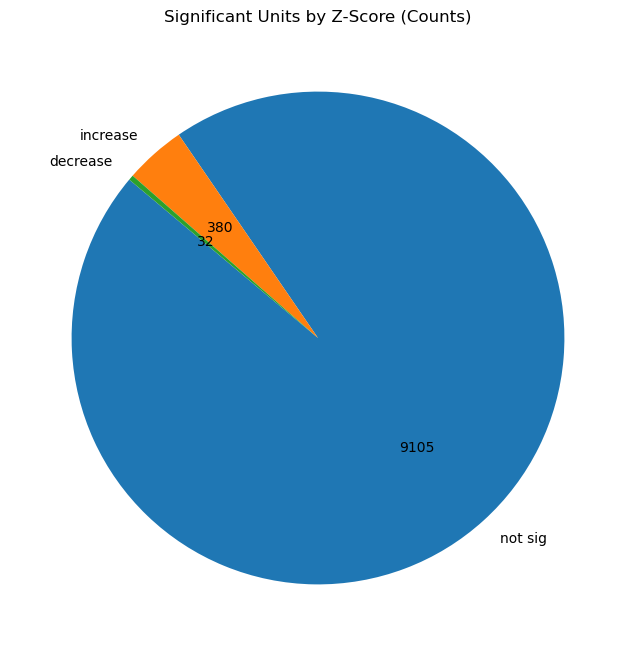

In [50]:
# Modified pie chart function
def plot_significant_units(df):
    """
    Plots a pie chart of significant units based on z-scores using raw counts instead of percentages.
    """
    if df.empty:
        print("No data to plot.")
        return

    # Count occurrences of each significance level
    sig_counts = df['sig'].value_counts()

    # Define a function to show raw counts
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            count = int(round(pct * total / 100.0))
            return f'{count}'  # Just show the count
        return my_autopct

    # Create pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sig_counts, labels=sig_counts.index, autopct=make_autopct(sig_counts), startangle=140)
    plt.title('Significant Units by Z-Score (Counts)')
    plt.show()

# Plot significant units for the combined DataFrame
plot_significant_units(combined_df)

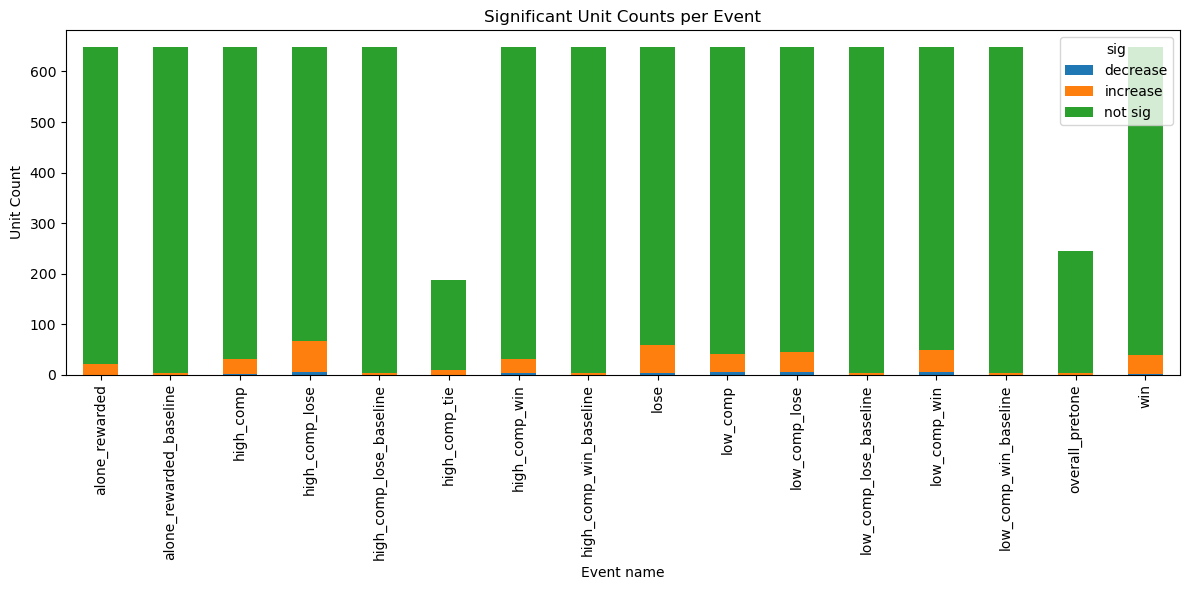

In [51]:
sig_summary = combined_df.groupby(['Event name', 'sig']).size().unstack(fill_value=0)
sig_summary.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Significant Unit Counts per Event")
plt.ylabel("Unit Count")
plt.tight_layout()
plt.show()


In [52]:
# Path to your UMAP file
umap_path = r'C:\Users\thoma\Code\ResearchCode\diff_fam_social_memory_ephys\other_peoples_sutff\Thomas\data\umap_df_detail.pkl'

# Load UMAP detail dataframe
umap_df_detail = pd.read_pickle(umap_path)

# Standardize both to integer, then string
combined_df['Unit number'] = combined_df['Unit number'].astype(float).astype(int).astype(str)
umap_df_detail['unit_id'] = umap_df_detail['unit_id'].astype(float).astype(int).astype(str)


# Merge with z-score data
merged_df = combined_df.merge(
    umap_df_detail[['recording_name', 'unit_id', 'cluster_id']],
    how='left',
    left_on=['Recording', 'Unit number'],
    right_on=['recording_name', 'unit_id']
)

# Assign putative type
merged_df['putative type'] = merged_df['cluster_id'].apply(lambda x: 'interneuron' if x == 5 else 'pyramidal')

# Drop extra columns
merged_df = merged_df.drop(columns=['recording_name', 'unit_id', 'cluster_id'])

merged_df.head()


,Recording,Event name,Unit number,Global Pre-event M,Global Pre-event SD,Event M,Event Z-Score,sig,putative type
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,104,0.939130,1.459821,0.75,-0.129557,not sig,pyramidal
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,11,3.191304,4.476306,2.70,-0.109757,not sig,pyramidal
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,122,1.434783,3.471325,1.85,0.119614,not sig,pyramidal
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,125,10.554348,8.245900,6.90,-0.443171,not sig,pyramidal
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,126,43.439130,33.150621,32.15,-0.340541,not sig,pyramidal


In [53]:
# How many units were labeled as cluster 5 (interneuron)?
print(umap_df_detail['cluster_id'].value_counts())

# Optional: Show examples
print("\nSample of cluster_id == 5:")
print(umap_df_detail[umap_df_detail['cluster_id'] == 5].head())

cluster_id
1     50
3     37
5     37
8     35
13    33
6     32
7     31
11    30
2     30
14    29
4     29
12    26
15    24
9     23
17    19
0     18
16    14
10    12
Name: count, dtype: int64

Sample of cluster_id == 5:
           x         y  \
5   8.429071  6.574254   
14  8.495145  6.605867   
32  8.912711  6.237262   
34  8.772264  5.965566   
38  9.011839  6.354066   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    waveform  \
5        [0.08533206, 0.09058755, 0.0963365, 0.10308427, 0.10771858, 0.111078285, 0.117285796, 0.12182775, 0.12190291, 0

In [54]:
print(merged_df['putative type'].value_counts())
# print unique putative types
print("Unique putative types:", merged_df['putative type'].unique())

putative type
pyramidal      8975
interneuron     542
Name: count, dtype: int64
Unique putative types: ['pyramidal' 'interneuron']


In [55]:
from collections import defaultdict
import ast

def get_sig_event_counts_by_cell_type(df, relevant_events):
    """
    Returns dicts mapping signature patterns (e.g., ['comp_win']) to counts, grouped by cell type.
    Only includes rows where sig is increase or decrease.
    """
    # Filter to sig only
    df = df[df['sig'].isin(['increase', 'decrease'])]

    # Only keep relevant events
    df = df[df['Event name'].isin(relevant_events)]

    # Collect events per unit
    unit_event_dict = defaultdict(lambda: {'events': set(), 'cell_type': None})

    for _, row in df.iterrows():
        unit = (row['Recording'], row['Unit number'])
        event = row['Event name']
        unit_event_dict[unit]['events'].add(event)
        unit_event_dict[unit]['cell_type'] = row['putative type']

    # Convert event sets to strings for consistent labeling
    counts = {'pyramidal': defaultdict(int), 'interneuron': defaultdict(int)}
    for data in unit_event_dict.values():
        key = str(sorted(data['events']))  # e.g., ['comp_win', 'no_comp_win']
        counts[data['cell_type']][key] += 1

    return counts


In [56]:
print("Unique events in merged_df:")
print(merged_df['Event name'].unique())


Unique events in merged_df:
['alone_rewarded' 'alone_rewarded_baseline' 'high_comp' 'high_comp_lose'
 'high_comp_lose_baseline' 'high_comp_win' 'high_comp_win_baseline' 'lose'
 'low_comp' 'low_comp_lose' 'low_comp_lose_baseline' 'low_comp_win'
 'low_comp_win_baseline' 'overall_pretone' 'win' 'high_comp_tie']


In [57]:
# Define the relevant events used to create sig patterns
relevant_events = ['high_comp_lose', 'high_comp_win', 'low_comp_win', 'low_comp_lose']

print(merged_df[merged_df['Event name'].isin(relevant_events)]['sig'].value_counts())


sig
not sig     2407
increase     169
decrease      20
Name: count, dtype: int64


Counts by cell type and event pattern:
pyramidal:
  ['high_comp_win', 'low_comp_win']: 8
  ['low_comp_lose']: 29
  ['low_comp_win']: 25
  ['high_comp_lose', 'high_comp_win', 'low_comp_win']: 5
  ['high_comp_lose']: 38
  ['high_comp_lose', 'low_comp_lose']: 8
  ['high_comp_win']: 11
  ['low_comp_lose', 'low_comp_win']: 1
  ['high_comp_lose', 'high_comp_win']: 4
  ['high_comp_lose', 'high_comp_win', 'low_comp_lose']: 1
  ['high_comp_lose', 'low_comp_win']: 4
  ['high_comp_lose', 'low_comp_lose', 'low_comp_win']: 2
interneuron:
  ['high_comp_lose']: 2
  ['high_comp_win', 'low_comp_win']: 2
  ['low_comp_win']: 1
  ['low_comp_lose']: 1
  ['high_comp_lose', 'low_comp_lose']: 2


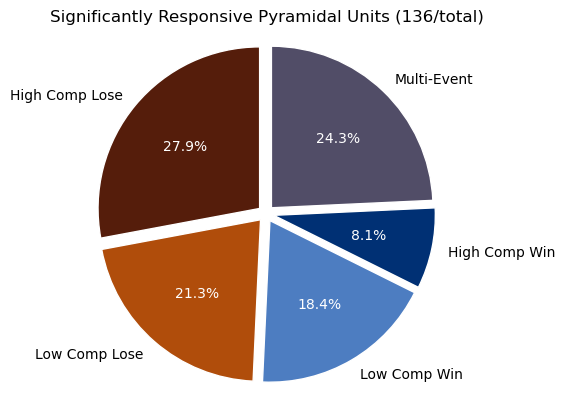

In [58]:
# Get counts
counts_dict = get_sig_event_counts_by_cell_type(merged_df, relevant_events)
print("Counts by cell type and event pattern:")
for cell_type, counts in counts_dict.items():
    print(f"{cell_type}:")
    for pattern, count in counts.items():
        print(f"  {pattern}: {count}")

# --- Pyramidal pie ---
pyr_counts = counts_dict['pyramidal']

# Group into categories
pyr_categories = {
    'High Comp Lose': {'count': pyr_counts.get("['high_comp_lose']", 0), 'color': '#551d0b'},
    'Low Comp Lose': {'count': pyr_counts.get("['low_comp_lose']", 0), 'color': '#b04d0b'},
    'Low Comp Win': {'count': pyr_counts.get("['low_comp_win']", 0), 'color': '#4d7dc1'},
    'High Comp Win': {'count': pyr_counts.get("['high_comp_win']", 0), 'color': '#003074'},
    'Multi-Event': {
        'count': sum(v for k, v in pyr_counts.items() if k not in [
            "['high_comp_lose']", "['low_comp_win']", "['high_comp_win']", "['low_comp_lose']"
        ]),
        'color': '#514D67'
    }
}


# Prepare pie data with NaN-safe check
labels = []
sizes = []
colors = []
explode = []

for label, values in pyr_categories.items():
    count = values['count']
    if not pd.isna(count) and count > 0:
        labels.append(label)
        sizes.append(count)
        colors.append(values['color'])
        explode.append(0.05)

# Handle case where no valid data is found
if not sizes or sum(sizes) == 0:
    print("⚠️ No non-zero or valid counts to plot for this group.")
else:
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(
        sizes, labels=labels, colors=colors, explode=explode,
        autopct=lambda pct: f'{pct:.1f}%', startangle=90,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )

    for autotext in autotexts:
        autotext.set_color('white')

    plt.title(f'Significantly Responsive Pyramidal Units ({sum(sizes)}/total)')
    ax.axis('equal')
    plt.show()


In [59]:
inter_counts = counts_dict['interneuron']
print(inter_counts)

defaultdict(<class 'int'>, {"['high_comp_lose']": 2, "['high_comp_win', 'low_comp_win']": 2, "['low_comp_win']": 1, "['low_comp_lose']": 1, "['high_comp_lose', 'low_comp_lose']": 2})


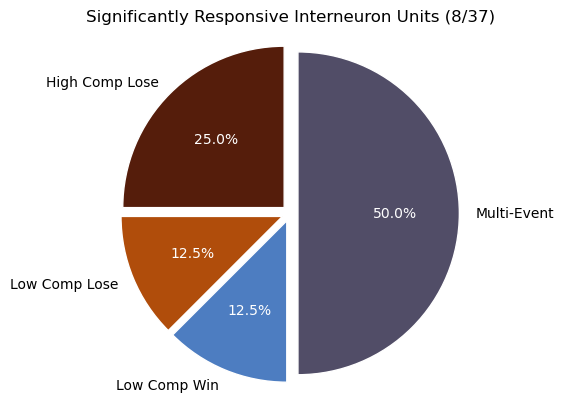

In [60]:
inter_categories = {
    'High Comp Lose': {
        'count': inter_counts.get("['high_comp_lose']", 0),
        'color': '#551d0b'
    },
    'Low Comp Lose': {
        'count': inter_counts.get("['low_comp_lose']", 0),
        'color': '#b04d0b'
    },
    'Low Comp Win': {
        'count': inter_counts.get("['low_comp_win']", 0),
        'color': '#4d7dc1'
    },
    'High Comp Win': {
        'count': inter_counts.get("['high_comp_win']", 0),  # not present in your counts, but included for contrast
        'color': '#003074'
    },
    'Multi-Event': {
        'count': sum(v for k, v in inter_counts.items() if k not in [
            "['high_comp_lose']",
            "['low_comp_lose']",
            "['low_comp_win']",
            "['high_comp_win']"
        ]),
        'color': '#514D67'
    }
}


# Prepare pie data
labels = list(inter_categories.keys())
sizes = [v['count'] for v in inter_categories.values()]
colors = [v['color'] for v in inter_categories.values()]
explode = [0.05] * len(labels)

# Filter out empty categories
labels, sizes, colors, explode = zip(*[
    (l, s, c, e) for l, s, c, e in zip(labels, sizes, colors, explode) if s > 0
])

# Create pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    sizes, labels=labels, colors=colors, explode=explode,
    autopct='%1.1f%%', startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)

# Style
for autotext in autotexts:
    autotext.set_color('white')

ax.axis('equal')
plt.title(f'Significantly Responsive Interneuron Units ({sum(sizes)}/{len(set(merged_df[merged_df["putative type"] == "interneuron"][["Recording", "Unit number"]].apply(tuple, axis=1)))})')

plt.show()



In [61]:
def generate_all_zscore_pie_plots(spike_collection, output_dir="pie_plots", SD=1.65, pre_window=10):
    import os
    import matplotlib.pyplot as plt
    from collections import Counter

    os.makedirs(output_dir, exist_ok=True)

    for rec in spike_collection.recordings:
        print(f"Processing recording: {rec.name}")
        for event_name in rec.event_dict.keys():
            try:
                df = run_zscore_global_baseline(rec, event_name, pre_window=pre_window, SD=SD)
                sig_counts = df["sig"].value_counts()
                
                # Ensure all 3 categories are represented for consistency
                labels = ["increase", "decrease", "not sig"]
                sizes = [sig_counts.get(label, 0) for label in labels]
                
                # Skip plotting if there's no data
                if sum(sizes) == 0:
                    print(f"Skipping {rec.name} - {event_name}: no data")
                    continue

                plt.figure(figsize=(5, 5))
                plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
                plt.axis('equal')
                plt.title(f"{event_name}\n{rec.name}", fontsize=10)
                
                # Save to file
                safe_rec_name = re.sub(r'[^\w\-_\. ]', '_', rec.name)  # Clean filename
                filename = f"{safe_rec_name}__{event_name}.png"
                filepath = os.path.join(output_dir, filename)
                plt.savefig(filepath, bbox_inches='tight')
                plt.close()
            except Exception as e:
                print(f"Error processing {rec.name}, {event_name}: {e}")


Counts by cell type and event pattern:
pyramidal:
  ['high_comp_win', 'low_comp_win']: 8
  ['low_comp_lose']: 29
  ['low_comp_win']: 25
  ['high_comp_lose', 'high_comp_win', 'low_comp_win']: 5
  ['high_comp_lose']: 38
  ['high_comp_lose', 'low_comp_lose']: 8
  ['high_comp_win']: 11
  ['low_comp_lose', 'low_comp_win']: 1
  ['high_comp_lose', 'high_comp_win']: 4
  ['high_comp_lose', 'high_comp_win', 'low_comp_lose']: 1
  ['high_comp_lose', 'low_comp_win']: 4
  ['high_comp_lose', 'low_comp_lose', 'low_comp_win']: 2
interneuron:
  ['high_comp_lose']: 2
  ['high_comp_win', 'low_comp_win']: 2
  ['low_comp_win']: 1
  ['low_comp_lose']: 1
  ['high_comp_lose', 'low_comp_lose']: 2


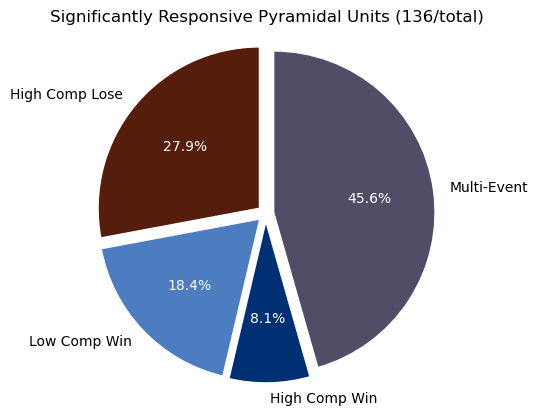

In [62]:
# Get counts
counts_dict = get_sig_event_counts_by_cell_type(merged_df, relevant_events)
print("Counts by cell type and event pattern:")
for cell_type, counts in counts_dict.items():
    print(f"{cell_type}:")
    for pattern, count in counts.items():
        print(f"  {pattern}: {count}")

# --- Pyramidal pie ---
pyr_counts = counts_dict['pyramidal']

# Group into categories
pyr_categories = {
    'High Comp Lose': {'count': pyr_counts.get("['high_comp_lose']", 0), 'color': '#551d0b'},
    'Low Comp Win': {'count': pyr_counts.get("['low_comp_win']", 0), 'color': '#4d7dc1'},
    'High Comp Win': {'count': pyr_counts.get("['high_comp_win']", 0), 'color': '#003074'},
    'Multi-Event': {
        'count': sum(v for k, v in pyr_counts.items() if k not in [
            "['high_comp_lose']", "['low_comp_win']", "['high_comp_win']"
        ]),
        'color': '#514D67'
    }
}


# Prepare pie data with NaN-safe check
labels = []
sizes = []
colors = []
explode = []

for label, values in pyr_categories.items():
    count = values['count']
    if not pd.isna(count) and count > 0:
        labels.append(label)
        sizes.append(count)
        colors.append(values['color'])
        explode.append(0.05)

# Handle case where no valid data is found
if not sizes or sum(sizes) == 0:
    print("⚠️ No non-zero or valid counts to plot for this group.")
else:
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(
        sizes, labels=labels, colors=colors, explode=explode,
        autopct=lambda pct: f'{pct:.1f}%', startangle=90,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )

    for autotext in autotexts:
        autotext.set_color('white')

    plt.title(f'Significantly Responsive Pyramidal Units ({sum(sizes)}/total)')
    ax.axis('equal')
    plt.show()



In [63]:
# use the function to generate pie plots
# generate_all_zscore_pie_plots(sp, output_dir="pie_plots", SD=1.65, pre_window=10)

In [64]:
def plot_significant_units_batch(spike_collection, SD=1.65, pre_window=10):
    """
    Loops through all recordings and events in a SpikeCollection and shows pie charts
    of significant units based on z-scores (increase, decrease, not sig).
    """
    import matplotlib.pyplot as plt

    for rec in spike_collection.recordings:
        print(f"\nProcessing recording: {rec.name}")
        for event_name in rec.event_dict.keys():
            try:
                df = run_zscore_global_baseline(rec, event_name, pre_window=pre_window, SD=SD)

                if df.empty or df['sig'].isna().all():
                    print(f"Skipping {event_name} in {rec.name}: no valid z-scores.")
                    continue

                sig_counts = df["sig"].value_counts()

                # Plot pie chart
                plt.figure(figsize=(8, 8))
                plt.pie(sig_counts, labels=sig_counts.index, autopct='%1.1f%%', startangle=140)
                plt.title(f'Significant Units by Z-Score\nEvent: {event_name}\nRecording: {rec.name}', fontsize=10)
                plt.show()

            except Exception as e:
                print(f"Error in {rec.name} - {event_name}: {e}")

In [65]:
# use the function to generate pie plots
# plot_significant_units_batch(sp, SD=1.65, pre_window=10)

## Ignore Below for now

In [66]:
stop

NameError: name 'stop' is not defined

### zscore for an event using only the baselines for that event type

In [ ]:
def run_zscore_per_event(recording, event_name, pre_window=10, SD=1.65, verbose=False):
    """
    For each 'good' unit, computes spike counts in event and pre-event baseline windows (in ms),
    runs z-scoring, and returns a DataFrame of results.

    Parameters:
    - recording: SpikeRecording object containing unit timestamps and event windows.
    - event_name: Name of the event to analyze (must be in recording.event_dict).
    - duration: Duration of the event window in seconds.
    - pre_window: Duration of the pre-event baseline window in seconds.
    - SD: Number of standard deviations for significance threshold in z-scoring.
    - verbose: If True, print debugging information.
    Returns:
    - A DataFrame with z-scored firing rates for each unit and event window.
    """
    event_windows = recording.event_dict[event_name]  # event dict values for the event time windows
    event_firing = {}
    baseline_firing = {}

    # Use .good_units if available, otherwise fallback to your original logic
    units = getattr(recording, "good_units", None)
    if units is None:
        units = [unit_id for unit_id, label in recording.labels_dict.items() if label == "good"]
    for unit_id in units:
        spikes = recording.unit_timestamps[unit_id]
        if verbose:
            print(f"\nConverting spikes for unit: {unit_id}\n")

        # Convert spike timestamps to milliseconds if needed
        spikes_ms = spikes * (1000 / recording.sampling_rate)

        event_counts = []
        baseline_counts = []
        for window in event_windows:
            start_event = window[0]
            end_event = window[1]

            if verbose:
                print(f"\nEvent window: {start_event}, {end_event} for unit {unit_id}\n")

            start_baseline = start_event - int(pre_window * 1000)
            end_baseline = start_event

            # Count spikes in each window
            event_count = np.sum((spikes_ms >= start_event) & (spikes_ms < end_event))
            baseline_count = np.sum((spikes_ms >= start_baseline) & (spikes_ms < end_baseline))

            event_counts.append(event_count)
            baseline_counts.append(baseline_count)

        if len(event_counts) == len(event_windows) and len(baseline_counts) == len(event_windows):
            event_firing[unit_id] = np.array(event_counts)
            baseline_firing[unit_id] = np.array(baseline_counts)

            if verbose:
                print(f"\nUnit {unit_id} - Event counts: {event_counts}, Baseline counts: {baseline_counts}\n")
        else:
            if verbose:
                print(f"\n\n---Skipping unit {unit_id} due to mismatched counts: {len(event_counts)} vs {len(event_windows)}---\n")

    # Filter out empty entries
    event_firing = {k: v for k, v in event_firing.items() if v.shape and v.shape[0] > 0}
    baseline_firing = {k: v for k, v in baseline_firing.items() if v.shape and v.shape[0] > 0}

    if verbose:
        print(f"\nevent_firing units: {len(event_firing)}")
        print(f"baseline_firing units: {len(baseline_firing)}\n")

    if not event_firing or not baseline_firing:
        if verbose:
            print("\n------------------------------------\nERROR: No valid units for z-scoring because of empty firing rates for all units.\n-------------------------------\n")
        return pd.DataFrame()

    # --- REPLACED RESULT-BUILDING SECTION ---
    rows = []

    for unit in event_firing:
        event_vals = event_firing[unit]
        baseline_vals = baseline_firing[unit]

        ev_mean = np.mean(event_vals)
        baseline_mean = np.mean(baseline_vals)
        baseline_sd = np.std(baseline_vals)

        if baseline_sd == 0:
            zscore = np.nan
        else:
            zscore = (ev_mean - baseline_mean) / baseline_sd

        sig = "not sig"
        if not np.isnan(zscore):
            if zscore > SD:
                sig = "increase"
            elif zscore < -SD:
                sig = "decrease"

        rows.append({
            "Recording": recording.name,
            "Event name": event_name,
            "Unit number": unit,
            "Pre-event M": baseline_mean,
            "Pre-event SD": baseline_sd,
            "Event M": ev_mean,
            "Event Z-Score": zscore,
            "sig": sig
        })

    df = pd.DataFrame(rows)
    return df


## Z-Score per event, use to compare to across all events z-score function to make sure it's working or to see if there's a difference

In [ ]:
rec = sp.recordings[0]
event_name = "alone_rewarded"  # or any event you know exists

df = run_zscore_per_event(rec, event_name, pre_window=10, SD=1.65)
df.head(20)

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,104,0.75,1.042833,0.75,0.000000,not sig
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,11,2.50,2.906888,2.70,0.068802,not sig
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,122,0.60,1.356466,1.85,0.921512,not sig
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,125,7.45,7.200521,6.90,-0.076383,not sig
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,126,40.10,25.238661,32.15,-0.314993,not sig
5,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,130,0.55,0.668954,1.05,0.747435,not sig
6,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,143,8.50,10.466614,9.70,0.114650,not sig
7,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,147,0.30,0.900000,0.60,0.333333,not sig
8,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,158,1.90,2.586503,5.70,1.469165,not sig
9,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,189,18.55,12.245305,18.15,-0.032666,not sig


### verbose version of z-score per event

In [ ]:
recording = sp.recordings[0]
event_name = "alone_rewarded"  # or any event you know exists

zscore_df = run_zscore_per_event(recording, event_name, pre_window=10, SD=1.65, verbose=True)
zscore_df.head(20)



Converting spikes for unit: 104


Event window: 1849109.9, 1859109.9 for unit 104


Event window: 1909109.85, 1919109.95 for unit 104


Event window: 1964109.8, 1974109.9 for unit 104


Event window: 2029109.75, 2039109.75 for unit 104


Event window: 2084109.85, 2094109.7 for unit 104


Event window: 2134109.8, 2144109.7 for unit 104


Event window: 2184109.75, 2194109.75 for unit 104


Event window: 2289109.55, 2299109.65 for unit 104


Event window: 2409109.6, 2419109.6 for unit 104


Event window: 2529109.4, 2539109.4 for unit 104


Event window: 2639109.3, 2649109.3 for unit 104


Event window: 2724109.35, 2734109.35 for unit 104


Event window: 2844109.3, 2854109.15 for unit 104


Event window: 2904109.1, 2914109.1 for unit 104


Event window: 2969109.05, 2979109.15 for unit 104


Event window: 3029109.15, 3039109.0 for unit 104


Event window: 3104108.95, 3114109.1 for unit 104


Event window: 3204108.9, 3214109.0 for unit 104


Event window: 3299108.95, 3309108.8 for unit 104


,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,104,0.75,1.042833,0.75,0.000000,not sig
1,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,11,2.50,2.906888,2.70,0.068802,not sig
2,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,122,0.60,1.356466,1.85,0.921512,not sig
3,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,125,7.45,7.200521,6.90,-0.076383,not sig
4,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,126,40.10,25.238661,32.15,-0.314993,not sig
5,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,130,0.55,0.668954,1.05,0.747435,not sig
6,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,143,8.50,10.466614,9.70,0.114650,not sig
7,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,147,0.30,0.900000,0.60,0.333333,not sig
8,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,158,1.90,2.586503,5.70,1.469165,not sig
9,20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec,alone_rewarded,189,18.55,12.245305,18.15,-0.032666,not sig


## Z-scoring for all recordings for alone_rewarded | Probably incorrect since it only finds baseline for singular recording instead of across all

In [ ]:
# loop through all recordings for 'alone_rewarded' event
all_zscore_dfs = []
for recording in sp.recordings:
    if 'alone_rewarded' in recording.event_dict:
        zscore_df = run_zscore_per_event(recording, 'alone_rewarded', pre_window=10, SD=1.65, verbose=False)
        if not zscore_df.empty:
            all_zscore_dfs.append(zscore_df)
# Combine all DataFrames into one
if all_zscore_dfs:
    combined_zscore_df = pd.concat(all_zscore_dfs, ignore_index=True)
    print("\nCombined Z-Score DataFrame for 'alone_rewarded' event:\n")
    print(combined_zscore_df.head(20))
else:
    print("\nNo valid z-score data found for 'alone_rewarded' event across recordings.\n")


Combined Z-Score DataFrame for 'alone_rewarded' event:

                                                                      Recording  \
0   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
1   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
2   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
3   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
4   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
5   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
6   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
7   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
8   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
9   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
10  20230612_101430_standard_c

In [ ]:
# show head of combined DataFrame wit column Event name == high_comp
if 'Event name' in combined_zscore_df.columns:
    high_comp_df = combined_zscore_df[combined_zscore_df['Event name'] == 'high_comp_win']
    print("\nCombined Z-Score DataFrame for 'high_comp' event:\n")
    print(high_comp_df.head(20))


Combined Z-Score DataFrame for 'high_comp' event:

Empty DataFrame
Columns: [Recording, Event name, Unit number, Pre-event M, Pre-event SD, Event M, Event Z-Score, sig]
Index: []


In [ ]:
# Create new z-score DataFrame for every event and recording
event_zscore_dfs = {}
for recording in sp.recordings:
    for event_name in recording.event_dict.keys():
        zscore_df = run_zscore_per_event(recording, event_name, pre_window=10, SD=1.65, verbose=False)
        if not zscore_df.empty:
            if event_name not in event_zscore_dfs:
                #print(f"{event_name} not in event_zscore_dfs, creating new list")
                event_zscore_dfs[event_name] = []
            #print(f"Appending zscore_df for event '{event_name}' from recording '{recording.name}'")
            event_zscore_dfs[event_name].append(zscore_df)
# Combine all DataFrames for each event into one
combined_event_zscore_dfs = {}
for event_name, dfs in event_zscore_dfs.items():
    #print(f"Combining {len(dfs)} DataFrames for event '{event_name}'")
    # Check if there are any DataFrames to combine
    if dfs:
        combined_event_zscore_dfs[event_name] = pd.concat(dfs, ignore_index=True)
# Print combined DataFrames for each event
for event_name, df in combined_event_zscore_dfs.items():
    print(f"\nCombined Z-Score DataFrame for '{event_name}' event:\n")
    print(df.head(20))

# create one DataFrame with all events and their z-scores
all_events_combined_df = pd.concat(combined_event_zscore_dfs.values(), ignore_index=True)



Combined Z-Score DataFrame for 'alone_rewarded' event:

                                                                      Recording  \
0   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
1   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
2   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
3   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
4   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
5   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
6   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
7   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
8   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
9   20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec   
10  20230612_101430_standard_c

In [ ]:
all_events_combined_df.tail(20)

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
6671,20240323_144517_alone_comp_subj_3-4_t6b6_merged.rec,high_comp_tie,32,39.0,6.0,64.0,4.166667,increase
6672,20240323_144517_alone_comp_subj_3-4_t6b6_merged.rec,high_comp_tie,4,157.5,2.5,150.0,-3.000000,decrease
6673,20240323_144517_alone_comp_subj_3-4_t6b6_merged.rec,high_comp_tie,7,3.5,0.5,1.5,-4.000000,decrease
6674,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_tie,0,11.0,5.0,51.5,8.100000,increase
6675,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_tie,12,0.0,0.0,0.5,NaN,not sig
6676,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_tie,18,86.0,11.0,107.5,1.954545,increase
6677,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_tie,24,6.5,2.5,59.5,21.200000,increase
6678,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_tie,25,1.5,0.5,1.5,0.000000,not sig
6679,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_tie,27,314.0,43.0,303.0,-0.255814,not sig
6680,20240323_165815_alone_comp_subj_4-2_t5b5_merged.rec,high_comp_tie,4,20.5,8.5,5.5,-1.764706,decrease


In [ ]:
# Modified pie chart function
def plot_significant_units(df):
    """
    Plots a pie chart of significant units based on z-scores using raw counts instead of percentages.
    """
    if df.empty:
        print("No data to plot.")
        return

    # Count occurrences of each significance level
    sig_counts = df['sig'].value_counts()

    # Define a function to show raw counts
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            count = int(round(pct * total / 100.0))
            return f'{count}'  # Just show the count
        return my_autopct

    # Create pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sig_counts, labels=sig_counts.index, autopct=make_autopct(sig_counts), startangle=140)
    plt.title('Significant Units by Z-Score (Counts)')
    plt.show()

# Plot significant units for the combined DataFrame
plot_significant_units(all_events_combined_df)

NameError: name 'all_events_combined_df' is not defined

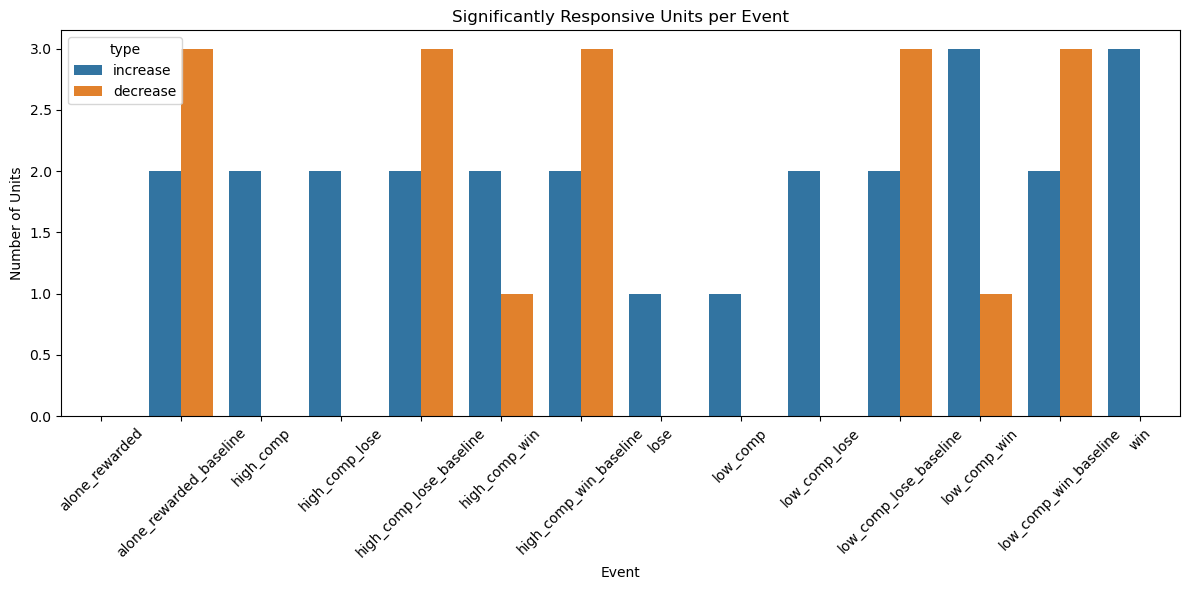

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine all z-scored DataFrames across events
event_names = ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'win']

summary_rows = []

for event in event_names:
    zscore_df = run_zscore_per_event(recording, event, pre_window=10, SD=1.65)
    if not zscore_df.empty:
        inc = (zscore_df["sig"] == "increase").sum()
        dec = (zscore_df["sig"] == "decrease").sum()
        summary_rows.append({'event': event, 'type': 'increase', 'count': inc})
        summary_rows.append({'event': event, 'type': 'decrease', 'count': dec})

summary_df = pd.DataFrame(summary_rows)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x='event', y='count', hue='type')
plt.xticks(rotation=45)
plt.title('Significantly Responsive Units per Event')
plt.ylabel('Number of Units')
plt.xlabel('Event')
plt.tight_layout()
plt.show()


In [ ]:
# Path to your UMAP file
umap_path = r'C:\Users\thoma\Code\ResearchCode\diff_fam_social_memory_ephys\other_peoples_sutff\Thomas\data\umap_df_detail.pkl'

# Load UMAP detail dataframe
umap_df_detail = pd.read_pickle(umap_path)

# Merge with z-score data
merged_df = all_events_combined_df.merge(
    umap_df_detail[['recording_name', 'unit_id', 'cluster_id']],
    how='left',
    left_on=['Recording', 'Unit number'],
    right_on=['recording_name', 'unit_id']
)

# Assign putative type
merged_df['putative type'] = merged_df['cluster_id'].apply(lambda x: 'interneuron' if x == 5 else 'pyramidal')

# Drop extra columns
merged_df = merged_df.drop(columns=['recording_name', 'unit_id', 'cluster_id'])

# Optional: View result
print(merged_df.head())


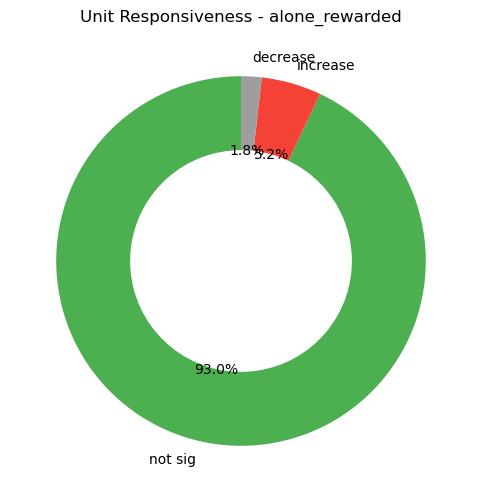

In [ ]:
def plot_donut_pie(event_df, event_name):
    counts = event_df['sig'].value_counts()
    labels = counts.index
    sizes = counts.values
    colors = ['#4caf50', '#f44336', '#9e9e9e']  # green, red, gray

    fig, ax = plt.subplots(figsize=(6, 6))
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%',
                                      colors=colors[:len(labels)],
                                      startangle=90, wedgeprops=dict(width=0.4))

    ax.set_title(f"Unit Responsiveness - {event_name}")
    plt.show()

# Example usage:
plot_donut_pie(all_events_combined_df, 'alone_rewarded')


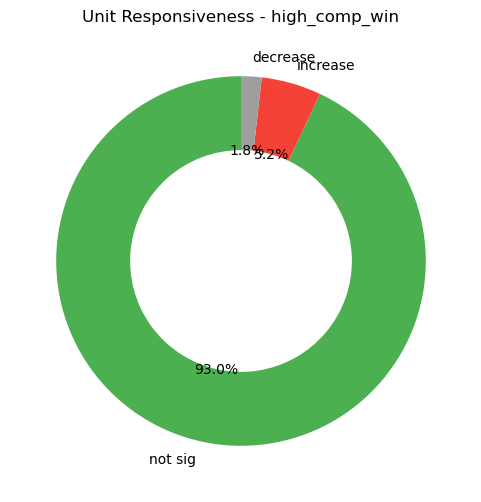

In [ ]:
plot_donut_pie(all_events_combined_df, 'high_comp_win')


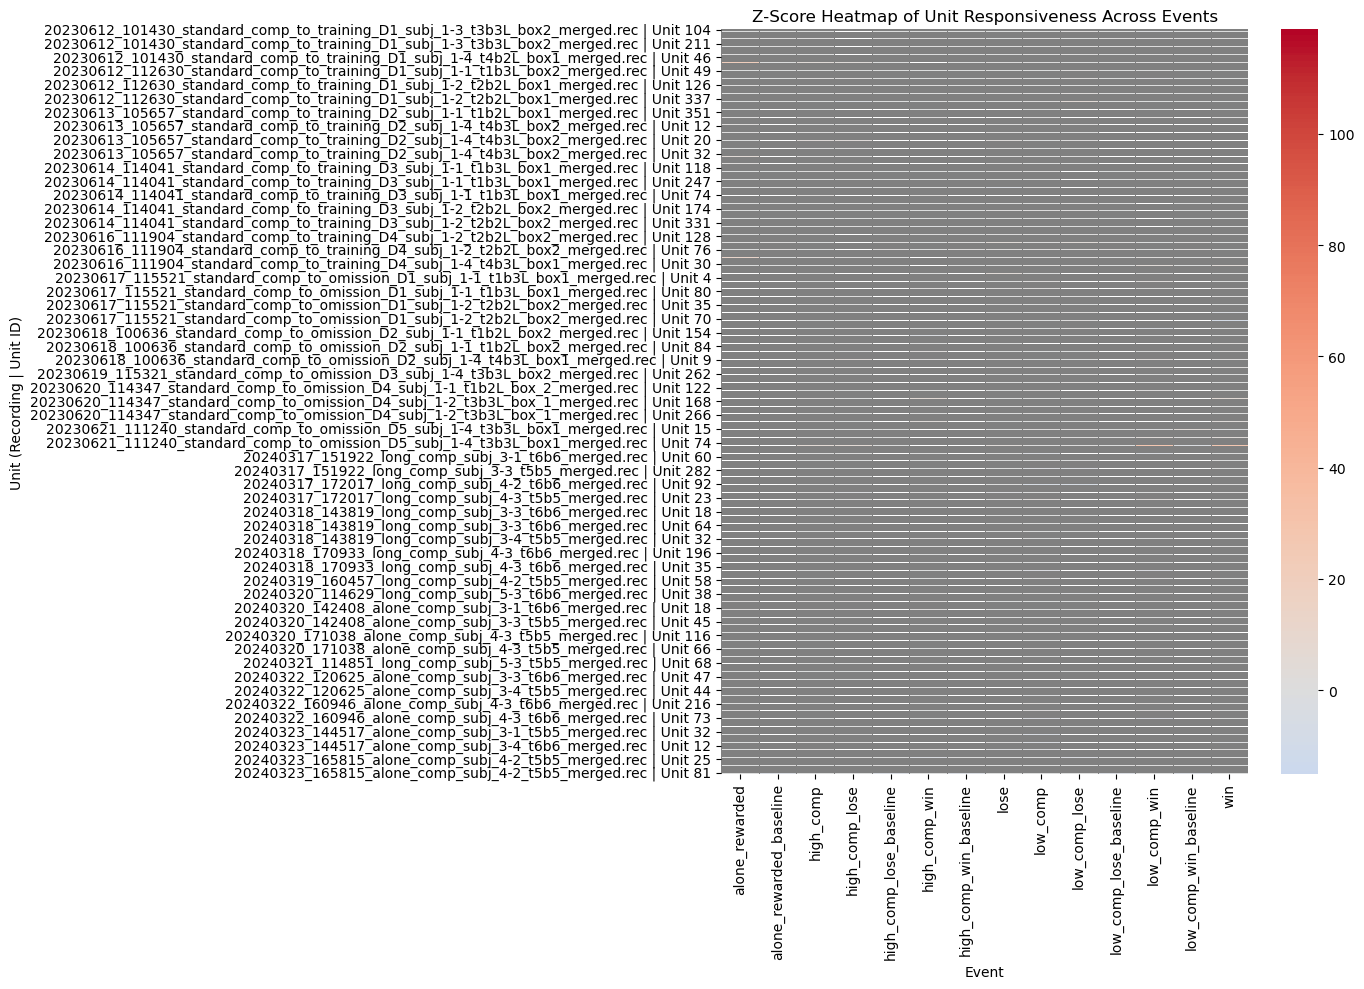

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of events to analyze (excluding baseline/tone-prep events)
event_list = ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'win']


# Collect z-scores across events
zscore_dfs = []

for event in event_list:
    for recording in sp.recordings:
        if event in recording.event_dict:
            df = run_zscore_per_event(recording, event, pre_window=10, SD=1.65, verbose=False)
            if not df.empty:
                zscore_dfs.append(df)

# Combine all into one long DataFrame
all_zscores = pd.concat(zscore_dfs, ignore_index=True)

# Create a unique unit label (Recording + Unit) to distinguish across sessions
all_zscores['Unique Unit'] = all_zscores['Recording'] + ' | Unit ' + all_zscores['Unit number'].astype(str)

# Pivot to get units as rows, events as columns
pivot_df = all_zscores.pivot(index='Unique Unit', columns='Event name', values='Event Z-Score')

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_df, cmap='coolwarm', center=0, linewidths=0.5, linecolor='gray')
plt.title("Z-Score Heatmap of Unit Responsiveness Across Events")
plt.xlabel("Event")
plt.ylabel("Unit (Recording | Unit ID)")
plt.tight_layout()
plt.show()


c:\Users\thoma\miniconda3\envs\ephys_env\lib\site-packages\matplotlib_venn\layout\venn3\pairwise.py:103: UserWarning: Circle A has zero area.
  warnings.warn("Circle A has zero area.")
c:\Users\thoma\miniconda3\envs\ephys_env\lib\site-packages\matplotlib_venn\layout\venn3\pairwise.py:107: UserWarning: Circle B has zero area.
  warnings.warn("Circle B has zero area.")


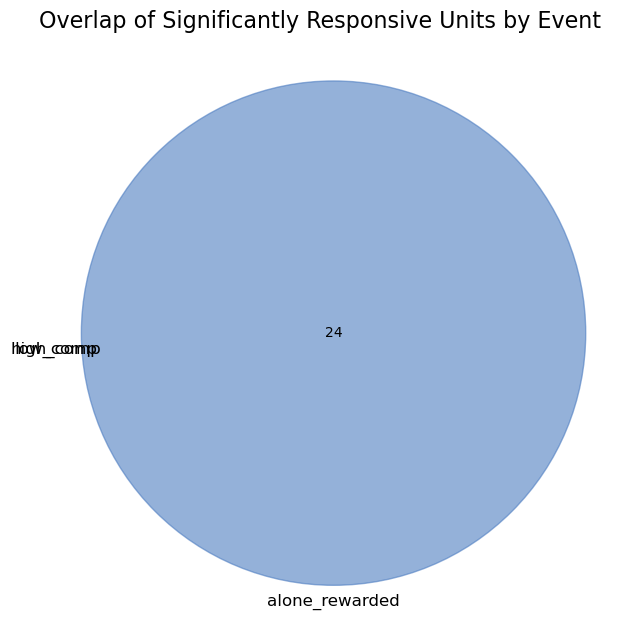

In [ ]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

# Step 1: Define the events you care about
# event_names = ['alone_rewarded', 'alone_rewarded_baseline', 'high_comp', 'high_comp_lose', 'high_comp_lose_baseline', 'high_comp_win', 'high_comp_win_baseline', 'lose', 'low_comp', 'low_comp_lose', 'low_comp_lose_baseline', 'low_comp_win', 'low_comp_win_baseline', 'win']


target_events = ['high_comp', 'low_comp', 'alone_rewarded']

# Step 2: Filter and collect significant units per event
event_sets = {event: set() for event in target_events}

for idx, row in combined_zscore_df.iterrows():
    if row['sig'] in ['increase', 'decrease']:  # only keep significant units
        event = row['Event name']
        if event in target_events:
            unique_id = (row['Recording'], row['Unit number'])  # uniquely identify unit across recordings
            event_sets[event].add(unique_id)

# Step 3: Extract sets in the same order
a = event_sets['high_comp']
b = event_sets['low_comp']
c = event_sets['alone_rewarded']

# Step 4: Plot Venn diagram
plt.figure(figsize=(8, 8))
v = venn3([a, b, c], set_labels=['high_comp', 'low_comp', 'alone_rewarded'])

# Optional: Set colors (same as in original script)
colors = {
    '100': '#003074',
    '010': '#551d0b',
    '001': '#4d7dc1',
    '110': '#2B2740',
    '101': '#27579B',
    '011': '#514D66',
    '111': '#3C5281'
}
for region, color in colors.items():
    patch = v.get_patch_by_id(region)
    if patch:
        patch.set_color(color)
        patch.set_alpha(0.6)

plt.title('Overlap of Significantly Responsive Units by Event', fontsize=16)
plt.show()
